In [2]:
import torch 
import xarray as xr
import os
import matplotlib.pyplot as plt

In [1]:
root="/r/scratch/users/mschillinger/data/cordexbench/"
domain="NZ"
training_experiment = 'Emulator_hist_future'
mode = "train" 
if mode == "train":
    folder = "train"
else:
    raise ValueError("In DownscalingDatasetNormed: mode not recognised")
        
if training_experiment == 'ESD_pseudo_reality':
    period_training = '1961-1980'
elif training_experiment == 'Emulator_hist_future':
    period_training = '1961-1980_2080-2099'
else:
    raise ValueError('Provide a valid date')

# Set the GCM
if domain == 'ALPS':
    gcm_name = 'CNRM-CM5'
elif domain == 'NZ' or domain == 'SA':
    gcm_name = 'ACCESS-CM2'
DATA_PATH = root + f"/{domain}/{domain}_domain"
hr_path = f'{DATA_PATH}/{folder}/{training_experiment}/target/pr_tasmax_{gcm_name}_{period_training}.nc'



In [3]:
xr.open_dataset(hr_path)    

<xarray.Dataset> Size: 3GB
Dimensions:  (time: 14600, lat: 128, lon: 128)
Coordinates:
  * time     (time) datetime64[ns] 117kB 1961-01-01 1961-01-02 ... 2099-12-31
  * lon      (lon) float32 512B 166.0 166.1 166.3 166.4 ... 179.5 179.6 179.7
  * lat      (lat) float32 512B -47.56 -47.46 -47.35 ... -34.15 -34.04 -33.93
Data variables:
    pr       (time, lat, lon) float64 2GB ...
    tasmax   (time, lat, lon) float32 957MB ...
Attributes: (12/28)
    CDI:             Climate Data Interface version 1.9.5 (http://mpimet.mpg....
    history:         Tue Mar 12 14:54:26 2024: cdo merge /nesi/project/niwa00...
    source:          CSIRO conformal-cubic model. Input file: surf.ccam_12km....
    Conventions:     CF-1.7
    title:           CCAM simulation data
    il:              288
    ...              ...
    BC_version:      no output bias correction
    CMOR_v:          v1.0 Public
    CDO_call:        daymean computed on hourly data
    project:         NIWA CMIP6 Downscaling
    contact:         Peter Gibson (peter.gibson@niwa.co.nz)
    CDO:             Climate Data Operators version 1.9.5 (http://mpimet.mpg....

In [5]:
xr.open_dataset(hr_path).time[:(14600//2)]

<xarray.DataArray 'time' (time: 7300)> Size: 58kB
array(['1961-01-01T00:00:00.000000000', '1961-01-02T00:00:00.000000000',
       '1961-01-03T00:00:00.000000000', ..., '1980-12-29T00:00:00.000000000',
       '1980-12-30T00:00:00.000000000', '1980-12-31T00:00:00.000000000'],
      shape=(7300,), dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 58kB 1961-01-01 1961-01-02 ... 1980-12-31

Processing pr
torch.Size([14600, 128, 128])
torch.Size([14600, 128, 128])
Processing tasmax
torch.Size([14600, 128, 128])
torch.Size([14600, 128, 128])


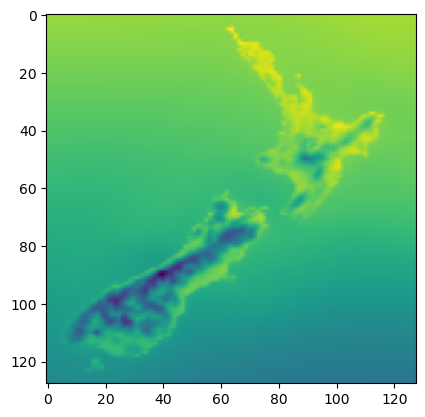

In [6]:
hr_ds = xr.open_dataset(hr_path).astype("float32")
for data_type in ["pr", "tasmax"]:
    print(f"Processing {data_type}")
    hr_data = torch.from_numpy(hr_ds[data_type].data)
    print(hr_data.shape)
    hr_data = torch.flip(hr_data, [1])
    print(hr_data.shape)
    if data_type in ["pr"]:
        hr_data = torch.sqrt(hr_data)

    # COMPUTE NORM STATS        
    hr_std_all = torch.std(hr_data)
    hr_mean_all = torch.mean(hr_data)

    if data_type in ["pr"]:
        name_str = "_sqrt"
    else:
        name_str = ""

    file_base = f"{training_experiment}_{data_type}_{gcm_name}_{period_training}{name_str}"

    torch.save({"mean": hr_mean_all, "std": hr_std_all},
        os.path.join(root, domain, "norm_stats", f"hr_norm_stats_full-data_{file_base}.pt"))

    hr_std_pw = torch.std(hr_data, dim=0)
    hr_mean_pw = torch.mean(hr_data, dim=0)

    torch.save({"mean": hr_mean_pw, "std": hr_std_pw},
        os.path.join(root, domain, "norm_stats", f"hr_norm_stats_pixelwise_{file_base}.pt"))

    hr_norm = (hr_data - hr_mean_pw) / hr_std_pw
    plt.imshow(hr_norm[0, :, :].detach().numpy())
    plt.imshow(hr_mean_pw.detach().numpy())


In [ ]:
# path: /r/scratch/users/mschillinger/data/cordexbench/ALPS/norm_stats/hr_norm_stats_pixelwise_Emulator_hist_future_tasmax_CNRM-CM5_1961-1980_2080-2099.pt

In [ ]:
import torch

In [ ]:
hr_path = "/r/scratch/users/mschillinger/data/cordexbench/ALPS/norm_stats/hr_norm_stats_pixelwise_Emulator_hist_future_tasmax_CNRM-CM5_1961-1980_2080-2099.pt"
torch.load(hr_path)

{'mean': tensor([[286.2697, 286.2741, 286.2914,  ..., 287.7368, 287.6093, 287.5016],
         [286.3308, 286.2510, 286.2050,  ..., 287.4727, 287.4353, 287.5070],
         [286.2915, 286.3274, 286.2786,  ..., 287.3528, 287.2807, 287.1166],
         ...,
         [293.8380, 293.9804, 293.7415,  ..., 292.9789, 293.1177, 293.0654],
         [294.5229, 294.5119, 294.0963,  ..., 293.0679, 293.0404, 293.0449],
         [295.3590, 296.2380, 297.0584,  ..., 293.1179, 293.0996, 293.1055]]),
 'std': tensor([[ 4.8394,  4.8456,  4.8750,  ..., 11.5365, 11.4934, 11.5613],
         [ 4.7761,  4.7966,  4.8106,  ..., 11.4700, 11.4732, 11.5344],
         [ 4.7375,  4.7414,  4.7576,  ..., 11.4719, 11.4513, 11.5013],
         ...,
         [ 4.6028,  4.7120,  4.6753,  ...,  5.1270,  5.0859,  5.1018],
         [ 5.2988,  5.5773,  5.2468,  ...,  5.1122,  5.0928,  5.0885],
         [ 7.4674,  7.4854,  7.3050,  ...,  5.0882,  5.0883,  5.0834]])}

In [6]:
hr_path = "/r/scratch/users/mschillinger/data/cordexbench/ALPS/norm_stats/hr_norm_stats_pixelwise_tasmax_train_ALL.pt"
torch.load(hr_path)["mean"].shape

torch.Size([128, 128])

In [7]:
lr_path = f'{DATA_PATH}/{folder}/{training_experiment}/predictors/{gcm_name}_{period_training}.nc'

In [8]:
lr_ds = xr.open_dataset(lr_path).astype("float32")

In [9]:
lr_ds

<xarray.Dataset> Size: 224MB
Dimensions:  (time: 14600, lat: 16, lon: 16)
Coordinates:
  * lon      (lon) float64 128B 157.5 159.5 161.5 163.5 ... 183.5 185.5 187.5
  * lat      (lat) float64 128B -55.5 -53.5 -51.5 -49.5 ... -29.5 -27.5 -25.5
  * time     (time) datetime64[ns] 117kB 1961-01-01 1961-01-02 ... 2099-12-31
Data variables: (12/15)
    u_850    (time, lat, lon) float32 15MB 8.11 9.302 10.2 ... -9.315 -9.562
    u_700    (time, lat, lon) float32 15MB 7.54 8.932 10.55 ... -7.361 -7.061
    u_500    (time, lat, lon) float32 15MB 12.62 11.78 12.47 ... -7.561 -9.616
    v_850    (time, lat, lon) float32 15MB 6.026 5.84 5.395 ... -0.7705 -0.4288
    v_700    (time, lat, lon) float32 15MB 4.61 5.1 4.402 ... -1.185 -0.9904
    v_500    (time, lat, lon) float32 15MB 8.158 8.447 6.162 ... -3.52 -4.031
    ...       ...
    t_850    (time, lat, lon) float32 15MB 268.9 269.2 269.2 ... 290.8 290.3
    t_700    (time, lat, lon) float32 15MB 260.7 260.7 260.6 ... 284.6 285.0
    t_500    (time, lat, lon) float32 15MB 244.9 243.8 243.2 ... 268.3 268.3
    z_850    (time, lat, lon) float32 15MB 1.259e+03 1.248e+03 ... 1.6e+03
    z_700    (time, lat, lon) float32 15MB 2.767e+03 2.758e+03 ... 3.243e+03
    z_500    (time, lat, lon) float32 15MB 5.259e+03 5.243e+03 ... 5.968e+03
Attributes: (12/259)
    CDI:                  Climate Data Interface version 1.9.5 (http://mpimet...
    history:              Tue Jun 17 10:30:52 2025: cdo -L -mergetime -daymea...
    source:               CSIRO conformal-cubic model. Input file: ccam_12km....
    Conventions:          CF-1.7
    title:                CCAM simulation data
    contact:              ccam@csiro.au
    ...                   ...
    ateb_minsnowden:      100.0
    ateb_ncyits:          6
    ateb_nfgits:          3
    ateb_nrefl:           3
    ateb_refheight:       0.6
    ateb_resmeth:         1

In [10]:
for data_type in lr_ds.data_vars.keys():
    if data_type == "time_bnds":
        continue
    print(f"Processing {data_type}")
    lr_data = torch.flip(torch.from_numpy(lr_ds[data_type].data), [1])
        
    if data_type in ["pr", "sfcWind"]:
        lr_data = torch.sqrt(lr_data)

    if data_type in ["pr", "sfcWind"]:
        name_str = "_sqrt"
    else:
        name_str = ""

    # COMPUTE NORM STATS
    lr_std_all = torch.std(lr_data)
    lr_mean_all = torch.mean(lr_data)
    
    #torch.save({"mean": hr_mean_all, "std": hr_std_all},
    #    os.path.join(root, domain, "norm_stats", f"hr_norm_stats_full-data_{file_base}.pt"))
    
    file_base = f"{training_experiment}_{data_type}_{gcm_name}_{period_training}{name_str}"
    print(os.path.join(root, domain, "norm_stats", f"lr_norm_stats_full-data_{file_base}.pt"))
    torch.save({"mean": lr_mean_all, "std": lr_std_all},
        os.path.join(root, domain, "norm_stats", f"lr_norm_stats_full-data_{file_base}.pt"))
    
    lr_std_pw = torch.std(lr_data, dim=0)
    lr_mean_pw = torch.mean(lr_data, dim=0)

    torch.save({"mean": lr_mean_pw, "std": lr_std_pw},
        os.path.join(root, domain, "norm_stats", f"lr_norm_stats_pixelwise_{file_base}.pt"))

Processing u_850
/r/scratch/users/mschillinger/data/cordexbench/NZ/norm_stats/lr_norm_stats_full-data_Emulator_hist_future_u_850_ACCESS-CM2_1961-1980_2080-2099.pt
Processing u_700
/r/scratch/users/mschillinger/data/cordexbench/NZ/norm_stats/lr_norm_stats_full-data_Emulator_hist_future_u_700_ACCESS-CM2_1961-1980_2080-2099.pt
Processing u_500
/r/scratch/users/mschillinger/data/cordexbench/NZ/norm_stats/lr_norm_stats_full-data_Emulator_hist_future_u_500_ACCESS-CM2_1961-1980_2080-2099.pt
Processing v_850
/r/scratch/users/mschillinger/data/cordexbench/NZ/norm_stats/lr_norm_stats_full-data_Emulator_hist_future_v_850_ACCESS-CM2_1961-1980_2080-2099.pt
Processing v_700
/r/scratch/users/mschillinger/data/cordexbench/NZ/norm_stats/lr_norm_stats_full-data_Emulator_hist_future_v_700_ACCESS-CM2_1961-1980_2080-2099.pt
Processing v_500
/r/scratch/users/mschillinger/data/cordexbench/NZ/norm_stats/lr_norm_stats_full-data_Emulator_hist_future_v_500_ACCESS-CM2_1961-1980_2080-2099.pt
Processing q_850
/r/sc